In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from prompt_toolkit.input import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Load and Prepare Data

### Pending
* Feature Importance using XGBoost
* DIFFERENT Viz
* Prophet

In [66]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
data_path = 'data/AAPL.csv'
df = pd.read_csv(data_path)

# Parse the 'Date' column and add it as a feature
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].map(lambda x: x.toordinal())  # Convert Date to numerical format

# Display basic information
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,723161,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,723164,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,723165,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,723166,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,723167,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


<Axes: xlabel='Close', ylabel='Density'>

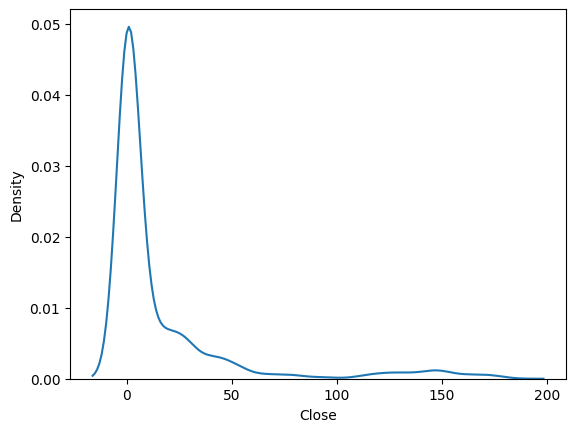

In [67]:
import seaborn as sns
sns.kdeplot(df['Close'])

In [73]:
# Normalize all features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns=['Close']))  # Scale input features

# Scale the target column 'Close'
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = target_scaler.fit_transform(df[['Close']])

# Define a function to create sequences for features and target
def create_sequences_multivariate(data, target, lookback):
    sequences = []
    targets = []
    for i in range(lookback, len(data)):
        sequences.append(data[i - lookback:i, :])  # Feature sequences
        targets.append(target[i, 0])  # Corresponding target value
    return np.array(sequences), np.array(targets)

# Set lookback window size
lookback = 30

# Create sequences for features and target
X, y = create_sequences_multivariate(scaled_data, scaled_close, lookback)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print data shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (7392, 30, 6), y_train shape: (7392,)
X_val shape: (1584, 30, 6), y_val shape: (1584,)
X_test shape: (1584, 30, 6), y_test shape: (1584,)


### 1. Simple `SimpleRNN`

In [1]:
# Model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input

# Define the SimpleRNN model
simple_rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(50, activation='tanh'),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with SGD optimizer and MSE loss
simple_rnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
simple_rnn_model.summary()

2024-12-02 15:56:56.098478: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 15:56:56.180223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733173016.214752    7386 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733173016.224523    7386 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 15:56:56.302819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

NameError: name 'X_train' is not defined

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
history = simple_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0237 - mae: 0.0672 - val_loss: 8.9258e-05 - val_mae: 0.0079
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1051e-04 - mae: 0.0132 - val_loss: 4.7001e-04 - val_mae: 0.0203
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3485e-05 - mae: 0.0072 - val_loss: 5.8264e-04 - val_mae: 0.0233
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4228e-05 - mae: 0.0055 - val_loss: 7.8958e-04 - val_mae: 0.0276
Epoch 5/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7386e-05 - mae: 0.0047 - val_loss: 1.6497e-05 - val_mae: 0.0033
Epoch 6/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5152e-05 - mae: 0.0040 - val_loss: 3.8272e-05 - val_mae: 0.0055
Epoch 7/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6928e-05 - mae: 0.0034 - val_loss: 3.0160e-05 - val_mae: 0.0047
Epoch 8/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1962e-05 - mae: 0.0027 - val_loss: 7.5831e-05 - val_mae: 0.0

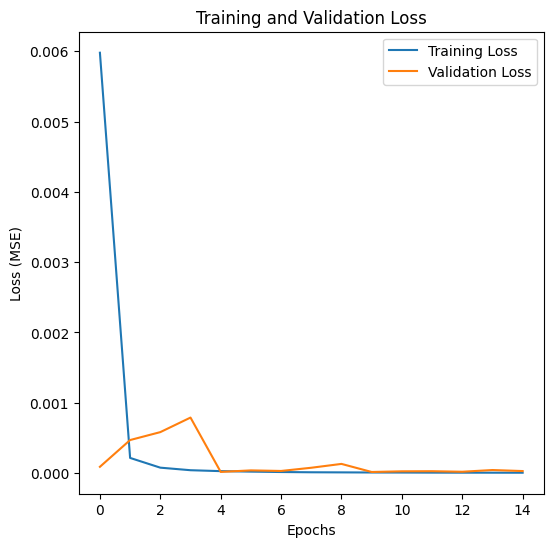

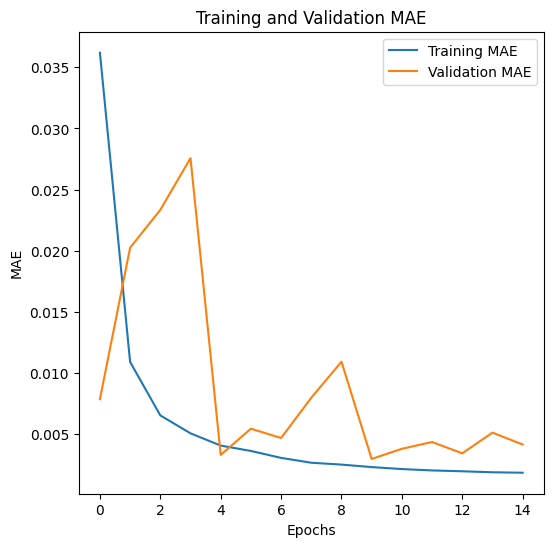

In [85]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

### 2. Sophisticated `SimpleRNN`

In [2]:
# Model 2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Define the Sophisticated SimpleRNN model
sophisticated_rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(64, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with Adam optimizer and MSE loss
sophisticated_rnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
sophisticated_rnn_model.summary()

NameError: name 'X_train' is not defined

In [90]:
# Train the model
history_sophisticated = sophisticated_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4411 - mae: 0.1517 - val_loss: 0.0234 - val_mae: 0.0895
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - mae: 0.0066 - val_loss: 0.0122 - val_mae: 0.1043
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0093e-04 - mae: 0.0067 - val_loss: 0.0126 - val_mae: 0.1062
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6893e-05 - mae: 0.0064 - val_loss: 0.0120 - val_mae: 0.1032
Epoch 5/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0178e-04 - mae: 0.0068 - val_loss: 0.0124 - val_mae: 0.1054
Epoch 6/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9031e-05 - mae: 0.0067 - val_loss: 0.0123 - val_mae: 0.1050
Epoch 7/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.9151e-05 - mae: 0.0066 - val_loss: 0.0118 - val_mae: 0.1023
Epoch 8/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5819e-05 - mae: 0.0065 - val_loss: 0.0120 - val_mae: 0.1032
Epoch 9/15
231/231 ━━━━━━━━━━━━━

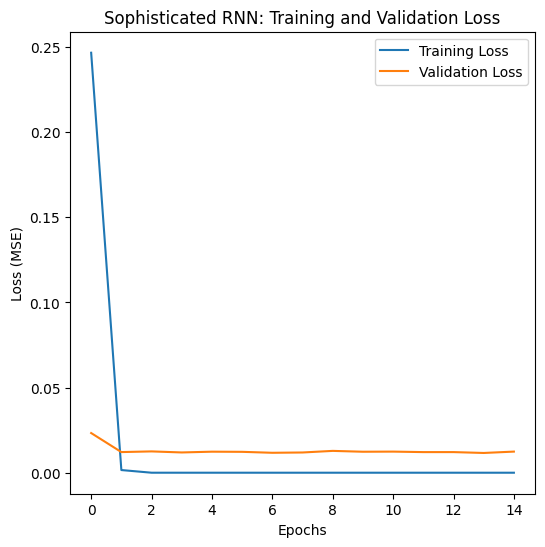

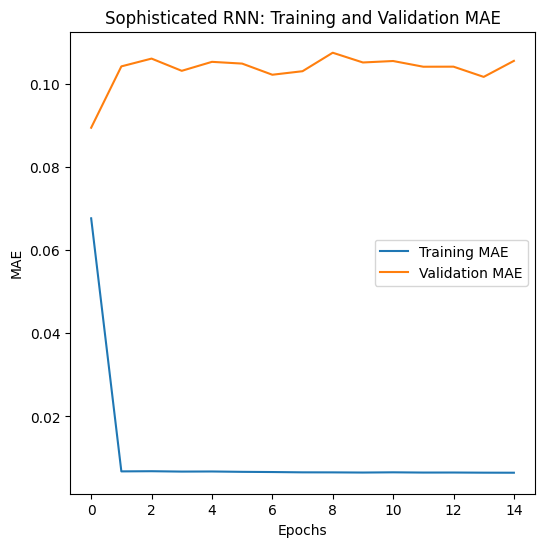

In [92]:
# Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history_sophisticated.history['loss'], label='Training Loss')
plt.plot(history_sophisticated.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Sophisticated RNN: Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history_sophisticated.history['mae'], label='Training MAE')
plt.plot(history_sophisticated.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Sophisticated RNN: Training and Validation MAE')
plt.show()

### 3. `GRU`

In [3]:
# Model 3
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(16, activation='tanh', return_sequences=True),
    Dropout(0.2),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with Adam optimizer and MSE loss
gru_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
gru_model.summary()

NameError: name 'X_train' is not defined

In [108]:
# Train the GRU model
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - mae: 0.0302 - val_loss: 0.0056 - val_mae: 0.0706
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8864e-04 - mae: 0.0101 - val_loss: 0.0078 - val_mae: 0.0830
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3087e-04 - mae: 0.0081 - val_loss: 0.0100 - val_mae: 0.0950
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1548e-04 - mae: 0.0075 - val_loss: 0.0105 - val_mae: 0.0968
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1213e-04 - mae: 0.0073 - val_loss: 0.0115 - val_mae: 0.1018
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0874e-04 - mae: 0.0072 - val_loss: 0.0112 - val_mae: 0.1000
Epoch 7/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0839e-04 - mae: 0.0071 - val_loss: 0.0111 - val_mae: 0.0995
Epoch 8/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0273e-04 - mae: 0.0068 - val_loss: 0.0099 - val_mae: 0.0931
Epoch 9/30
231/231 ━━━━━━━━━

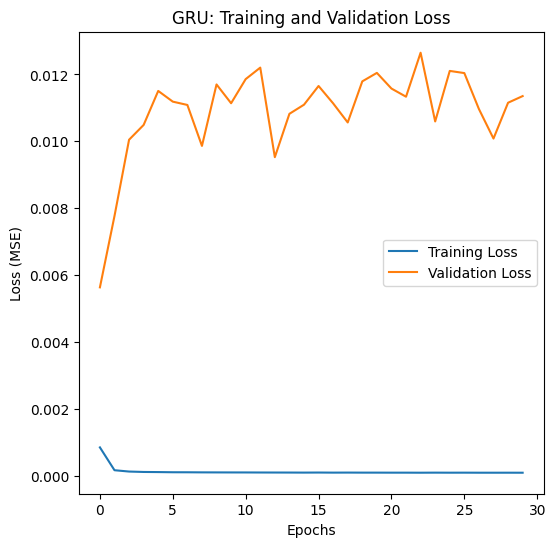

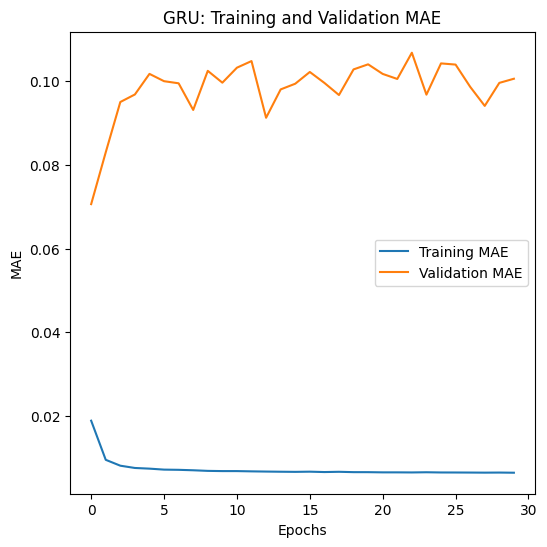

In [109]:
# Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('GRU: Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history_gru.history['mae'], label='Training MAE')
plt.plot(history_gru.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('GRU: Training and Validation MAE')
plt.show()

### Simple `SimpleRNN` with `Adam`

In [112]:
# Compile the model with SGD optimizer and MSE loss
simple_rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
simple_rnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 50)             │         2,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,901 (11.33 KB)

 Trainable params: 2,901 (11.33 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
# Train the model
history = simple_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5713e-06 - mae: 0.0018 - val_loss: 1.7047e-05 - val_mae: 0.0032
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8440e-07 - mae: 5.0764e-04 - val_loss: 3.5735e-05 - val_mae: 0.0050
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7581e-07 - mae: 6.5927e-04 - val_loss: 3.1295e-05 - val_mae: 0.0048
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0753e-06 - mae: 7.3395e-04 - val_loss: 1.2049e-05 - val_mae: 0.0025
Epoch 5/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8108e-07 - mae: 6.3028e-04 - val_loss: 2.6463e-05 - val_mae: 0.0041
Epoch 6/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0512e-06 - mae: 6.2443e-04 - val_loss: 9.1863e-06 - val_mae: 0.0022
Epoch 7/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2273e-07 - mae: 3.9770e-04 - val_loss: 3.9630e-05 - val_mae: 0.0050
Epoch 8/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3354e-06 - mae: 0.0010 - val_los

In [119]:
simple_rnn_model.evaluate(X_test, y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 2.3519e-04 - mae: 0.0084


[0.0010749255307018757, 0.02122870646417141]